# PySpark setup

In [18]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [19]:
!wget https://downloads.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz

--2023-11-21 20:13:04--  https://downloads.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
Resolving downloads.apache.org (downloads.apache.org)... 135.181.214.104, 88.99.95.219, 2a01:4f9:3a:2c57::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|135.181.214.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400395283 (382M) [application/x-gzip]
Saving to: ‘spark-3.5.0-bin-hadoop3.tgz’

spark-3.5.0-bin-had 100%[===================>] 381.85M  18.7MB/s    in 22s     

2023-11-21 20:13:26 (17.3 MB/s) - ‘spark-3.5.0-bin-hadoop3.tgz’ saved [400395283/400395283]



In [26]:
# !tar xzvf spark-3.5.0-bin-hadoop3.tgz

In [21]:
!pip install -q findspark

In [22]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

In [23]:
import findspark
findspark.init()

In [24]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, avg, when
import pandas as pd

In [25]:
sc = pyspark.SparkContext('local[*]')
spark = SparkSession(sc)
spark

# Upload data

In [164]:
import pandas as pd
import matplotlib.pyplot as plt

In [192]:
df = spark.read.option("multiline","true").json('/content/changes_enwiki_1000_sec.json')

In [114]:
# df.columns

In [193]:
df.show(5)

+--------------------+-----+--------------------+----------+--------------+--------------------+-----+---------+--------------------+--------------------+--------------------+----------------+------------------+--------------------+----------+--------------------+--------------------+----+---------------+------+
|             $schema|  bot|             comment|        id|        length|                meta|minor|namespace|          notify_url|       parsedcomment|            revision|     server_name|server_script_path|          server_url| timestamp|               title|           title_url|type|           user|  wiki|
+--------------------+-----+--------------------+----------+--------------+--------------------+-----+---------+--------------------+--------------------+--------------------+----------------+------------------+--------------------+----------+--------------------+--------------------+----+---------------+------+
|/mediawiki/recent...|false|       /* Descent */|169676649

In [194]:
df.count()

260

# Describe the distribution of edits per users and bots

In [198]:
df_bot_distr = df.select('user', 'bot').toPandas().drop_duplicates()

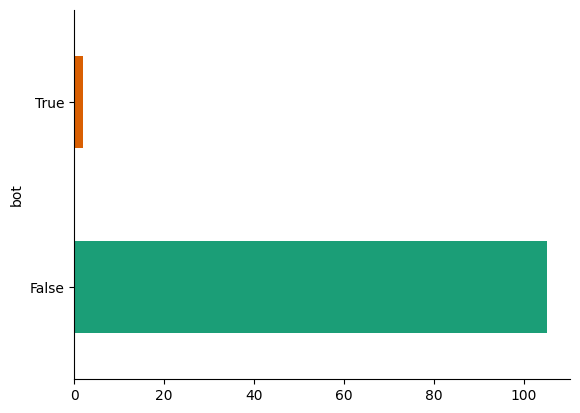

In [201]:
from matplotlib import pyplot as plt
import seaborn as sns
df_bot_distr.groupby('bot').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [58]:
df_users = df.filter(df.bot == 'false').groupBy('user').count().toPandas()

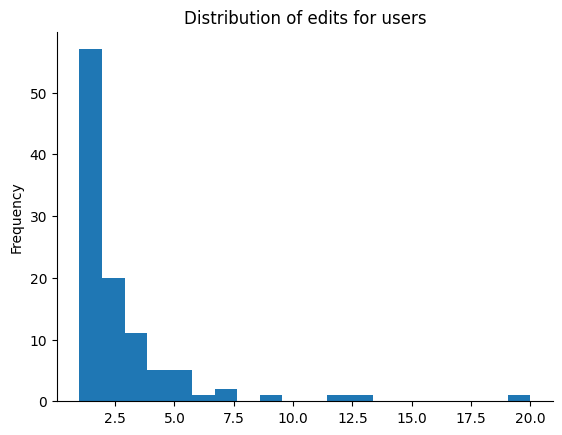

In [83]:
from matplotlib import pyplot as plt
df_users['count'].plot(kind='hist', bins=20, title='Distribution of edits for users')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [66]:
df_bots = df.filter(df.bot == 'true').groupBy('user').count().toPandas()

In [129]:
df_bots

,user,count
0,Citation bot,10
1,JJMC89 bot,1


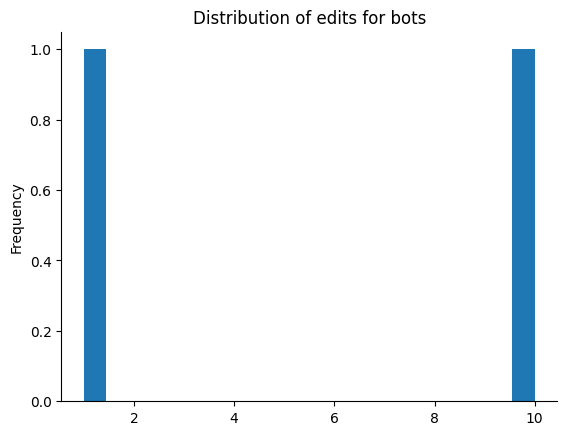

In [84]:
from matplotlib import pyplot as plt
df_bots['count'].plot(kind='hist', bins=20, title='Distribution of edits for bots')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Train bot detection model

In [202]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

# the average length of all edits per user as a feature
@udf(IntegerType())
def diff_length(length):
  old = length[0]
  new = length[1]
  return abs(new - old)

In [203]:
df = df.withColumn("length_difference", diff_length(df["length"]))

In [204]:
df = df.select('bot', 'length_difference', 'user')

In [205]:
from pyspark.sql.functions import count, mean, first

grouped_df = df.groupBy("user").agg(
    count("user").alias("count"),
    mean("length_difference").alias("mean_length_difference"),
    first("bot").alias("bot")
)

In [213]:
grouped_df.show(5)

+------------------+-----+----------------------+-----+
|              user|count|mean_length_difference|  bot|
+------------------+-----+----------------------+-----+
|    185.133.44.253|    1|                  34.0|false|
|Maxwell King123321|    2|                  44.0|false|
|   DanTheMusicMan2|   12|                124.75|false|
|      Citation bot|   10|                  29.6| true|
|        Burzuchius|    1|                  18.0|false|
+------------------+-----+----------------------+-----+
only showing top 5 rows



In [238]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import when

assembler = VectorAssembler(
  inputCols=["count", 'mean_length_difference'], outputCol="features"
)

assembled = assembler.transform(grouped_df)

In [239]:
assembled = assembled.withColumnRenamed("bot", "label").select('features', 'label')
assembled = assembled.withColumn('label', when(assembled.label, 1.0).otherwise(0.0))

In [240]:
assembled.show(5)

+-------------+-----+
|     features|label|
+-------------+-----+
|   [1.0,34.0]|  0.0|
|   [2.0,44.0]|  0.0|
|[12.0,124.75]|  0.0|
|  [10.0,29.6]|  1.0|
|   [1.0,18.0]|  0.0|
+-------------+-----+
only showing top 5 rows



In [241]:
train_df, test_df = assembled.randomSplit(weights=[0.7,0.3], seed=100)
valid_df, test_df = test_df.randomSplit(weights=[0.5, 0.5], seed=100)

In [249]:
test_df.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|   11|
|  1.0|    1|
+-----+-----+



In [243]:
train_df.count(), test_df.count(), valid_df.count()

(77, 12, 18)

In [244]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=2)

In [245]:
model = rf.fit(train_df)

In [246]:
predictions = model.transform(test_df)

In [248]:
predictions.show()

+--------------------+-----+-------------+-----------+----------+
|            features|label|rawPrediction|probability|prediction|
+--------------------+-----+-------------+-----------+----------+
|           [1.0,0.0]|  0.0|    [2.0,0.0]|  [1.0,0.0]|       0.0|
|           [1.0,5.0]|  0.0|    [2.0,0.0]|  [1.0,0.0]|       0.0|
|           [1.0,9.0]|  0.0|    [2.0,0.0]|  [1.0,0.0]|       0.0|
|          [1.0,90.0]|  0.0|    [2.0,0.0]|  [1.0,0.0]|       0.0|
|         [1.0,120.0]|  0.0|    [2.0,0.0]|  [1.0,0.0]|       0.0|
|         [1.0,195.0]|  0.0|    [2.0,0.0]|  [1.0,0.0]|       0.0|
|         [1.0,334.0]|  0.0|    [2.0,0.0]|  [1.0,0.0]|       0.0|
|           [2.0,1.5]|  0.0|    [2.0,0.0]|  [1.0,0.0]|       0.0|
|          [2.0,22.5]|  0.0|    [2.0,0.0]|  [1.0,0.0]|       0.0|
|          [2.0,33.5]|  0.0|    [2.0,0.0]|  [1.0,0.0]|       0.0|
|[3.0,117.66666666...|  0.0|    [2.0,0.0]|  [1.0,0.0]|       0.0|
|         [10.0,29.6]|  1.0|    [2.0,0.0]|  [1.0,0.0]|       0.0|
+---------

In [263]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction")
metrics = MulticlassMetrics(predictions.select("prediction", "label").rdd)

# print(metrics.confusionMatrix().toArray())
print("Precision bot-class: ", metrics.precision(1.0))
print("Precision user-class: ", metrics.precision(0.0))
print("Recall bot-class: ", metrics.recall(1.0))
print("Recall user-class: ", metrics.recall(0.0))
print("Weighted F1-score: ", metrics.weightedFMeasure())

Precision bot-class:  0.0
Precision user-class:  0.9166666666666666
Recall bot-class:  0.0
Recall user-class:  1.0
Weighted F1-score:  0.8768115942028986
